# Event Detection

We expect that as something happens, individuals will tweet about it in real-time causing bursts in Twitter activity. In 2011 Twitter [blogged](https://blog.twitter.com/2011/global-pulse) about how their site's avtivity was a reflection of global pulse, citing when volume spiked over 5,000 tweets per second following an earthquake.

Within our event timeline, we can identify specific times that importance for summarization in this way. We can call these subevents.

Using theory related to anomaly detection in signal processing for time series data, we can identify patterns that may significantly deviate from an underlying distribution in the dataset. By computing an expected frequency of occurrences per time window we can measure differences in behavior above or below this level for an interval, which may indicate an event activity. Furthermore, by calculating this expected frequency using a historical moving average, this approach can easily be applied to online data.

Related Twitter-Specific Frameworks
- [Twitter's Breakout Detection](https://blog.twitter.com/2014/breakout-detection-in-the-wild)
- [Twitter's Anomoly Detection](https://blog.twitter.com/2015/introducing-practical-and-robust-anomaly-detection-in-a-time-series)

**Measurment:** We define our measure as volume of tweets per minute, and an anomoly in this frequency would indicate a subevent.

**Method:** Anomalies are then detected by measuring the deviation from an expected frequency. Expected frequency is calculated using simple moving average using a window of 5 minutes, otherwise known as rolling mean. The intensity of the subevent is then measured as the deviation from the expected, and can be used to set a dynamic threshold for summarizing those which are most significant.

$expected = \frac{1}{n} \sum_{i=0}^{n-1} y-i$

Simple outlier detection algorithms look at values greated than a number of standard deviations from mean. Since we are limited to summarizing only that data which we can communicate we set a fixed threshold.

Subevents are considered for summarization if $y_{i} - expected > threshold$ where *threshold* is dynamically computed to include top *k* number of subevents.

### Input
- event tweets

### Output
- for every event minute
    - the volume of tweets
    - subevent rank, measured as deviation in descending order

#### import tools

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import re

#### import data

In [310]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())

Enter Event Name: Xbox E3


In [311]:
df = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
df.shape

(86475, 35)

#### twitter_id as index

In [312]:
df.set_index('twitter_id', inplace=True)

## Rolling Mean

In [313]:
d = df.reset_index().set_index('created_at').groupby([pd.TimeGrouper(freq='T')])['twitter_id'].agg(['count'])

In [314]:
timeframe = pd.date_range(d.index.min(), d.index.max(), freq='T')
d = d.reindex(timeframe, fill_value=0)

In [315]:
window = 2

In [316]:
d['mean'] = d['count'].rolling(window=window).agg(['mean'])
d['std'] = d['count'].rolling(window=window).agg(['std'])

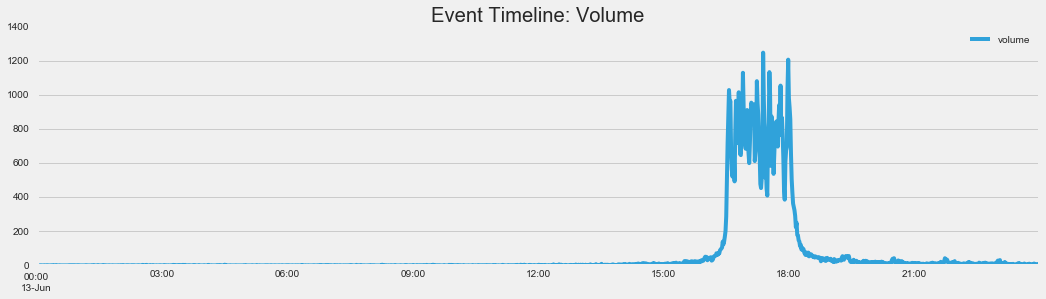

In [317]:
plt.title('Event Timeline: Volume')
ax = d['count'].plot(figsize=(16,4), label='volume')
plt.legend(loc='best')
plt.show()

#### zoom in at max event volume

In [318]:
#idxmax = d['count'].idxmax()
#zoommin = idxmax - pd.DateOffset(hours=1)
#zoommax = idxmax + pd.DateOffset(hours=1)

#plt.title('Zoomed Event Timeline: Volume \n (at peak %s)' % str(idxmax)[:16])
#ax = d[zoommin:zoommax]['count'].plot(figsize=(16,4), label='volume')
#d[zoommin:zoommax]['mean'].plot(ax=ax, style='g--', alpha=.70, label='rolling mean')
#(d[zoommin:zoommax]['mean'] + d[zoommin:zoommax]['std']).plot(ax=ax, color='r', alpha=.25, label='+1 std')
#ax.fill_between(d.index, d['mean'], d['mean'] + d['std'], alpha=.25, color='r')
#plt.legend(loc='best')
#plt.show()

## Rolling Mean Deviation

#### mark subevent if outside bounds of +1 standard deviation from rolling mean

In [319]:
d['deviation'] = d['count'] - d['mean']

In [320]:
#plt.title('Zoomed Event Timeline: Rolling Mean Deviation (+1 std)')
#ax = d[zoommin:zoommax]['deviation'].plot(figsize=(16,4), label='deviation')
#d[zoommin:zoommax]['std'].plot(ax=ax, color='r', alpha=.25, label='+1 std')
#####d[d['count'] > (d['mean'] + d['std'])][zoommin:zoommax]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
#ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
#ax.fill_between(d.index, 0, 0 + d['std'], alpha=.25, color='r')
#plt.legend(loc='best')
#plt.show()

In [321]:
#print('Total SubEvents:', d[d['count'] > (d['mean'] + d['std'])].shape[0])

#### use top k deviations from rolling mean

In [322]:
k = 20
threshold = d[d['deviation']>0]['deviation'].sort_values(ascending=False).iloc[:k].min()

In [323]:
#plt.title('Zoomed Event Timeline: Rolling Mean Deviation (Top k)')
#ax = d[zoommin:zoommax]['deviation'].plot(figsize=(16,4), label='deviation')
#d[d['deviation'] > threshold][zoommin:zoommax]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
#ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
#ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='threshold')
#ax.fill_between(d.index, 0, threshold, alpha=.25, color='r')
#plt.legend(loc='best')
#plt.show()

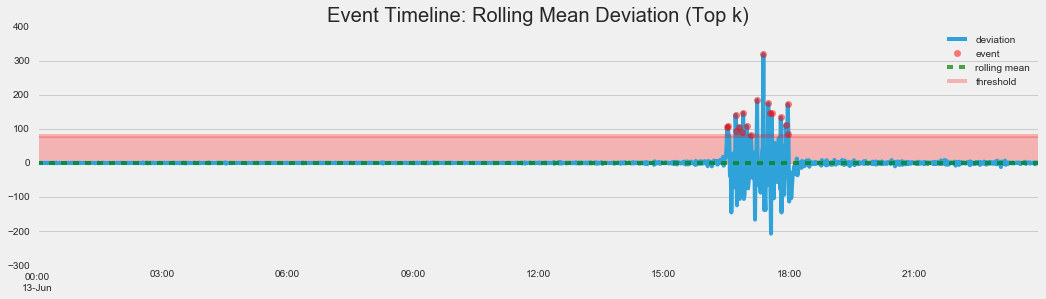

In [324]:
plt.title('Event Timeline: Rolling Mean Deviation (Top k)')
ax = d['deviation'].plot(figsize=(16,4), label='deviation')
d[d['deviation'] > threshold]['deviation'].plot(ax=ax, style='ro', alpha=.50, label='event')
ax.axhline(y=0, linestyle='--', c='g', alpha=.70, label='rolling mean')
ax.axhline(y=threshold, linestyle='-', color='r', alpha=.25, label='threshold')
ax.fill_between(d.index, 0, threshold, alpha=.25, color='r')
plt.legend(loc='best')
plt.show()

## Demo Event Viz Slicing on Subevents
#### use large top k threshold for dynamic event slicing

In [325]:
#viz_k = 100
#threshold_viz = d[d['deviation']>0]['deviation'].sort_values(ascending=False).iloc[:viz_k].min()
#viz_start = d[d['deviation'] > threshold_viz].index.min()
#viz_end = d[d['deviation'] > threshold_viz].index.max()

In [326]:
#plt.title('Event Timeline: Dynamic Event Slicing')
#ax = d['deviation'].plot(figsize=(16,4), label='deviation')
#ax.axhline(y=threshold_viz, linestyle='-', c='r', alpha=.25, label='threshold')
#ax.axvline(x=viz_start, linestyle='-', c='r', alpha=.25)
#ax.axvline(x=viz_end, linestyle='-', c='r', alpha=.25)
#ax.axvspan(0, viz_start, alpha=0.25, color='red')
#ax.axvspan(viz_end, d.index.max(), alpha=0.25, color='red')
#plt.legend(loc='best')
#plt.show()

In [327]:
#plt.title('Final Event Timeline: Top k Subevents')
#ax = d[viz_start:viz_end]['count'].plot(figsize=(16,4), label='volume')
#d[d['deviation'] > threshold]['count'].plot(ax=ax, style='ro', alpha=.50, label='event')
#plt.legend(loc='best')
#plt.show()

## Rank Subevent Times
- measure of subevent importance
- slice event
- export data

In [328]:
d['rank_subevents'] = d['deviation'].rank(axis=0, method='first', ascending=False)

#### output

In [329]:
d.to_csv('data/final/event_%s_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=True)

## Apply to All Events

#### add subevent info to data

In [330]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#import nltk
#import string

In [331]:
#make sure to handle text as string
#df['text'] = df['text'].astype('str')
#remove links
#df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))
#remove hashtag symbol
#df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))
#remove mention symbol
#df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))
#initiate, apply tokenization
#tknzr = nltk.TweetTokenizer()
#df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

In [332]:
#%%time
#df['stdz_frequency_1min'] = np.nan
#df['stdz_rollmean_frequency_win5min'] = np.nan
#df['stdz_rollmean_frequency_deviation'] = np.nan
#
#for event_df in allevents:
#
#    event_dist = event_df.set_index('created_at').groupby([pd.TimeGrouper(freq='min')])['twitter_id'].agg(['count'])
#    timeframe = pd.date_range(event_dist.index.min(), event_dist.index.max(), freq='T')
#    event_dist = event_dist.reindex(timeframe, fill_value=0)
#    
#    event_dist['mean'] = event_dist['count'].rolling(window=5).agg(['mean'])
#    event_dist['deviation'] = event_dist['count'] - event_dist['mean']    
#
#    event_temp = event_df[['twitter_id', 'created_at']]
#    event_temp['created_at'] = event_temp['created_at'].apply(lambda x: x.replace(second=0))
#    event_temp.set_index(['created_at'], inplace=True)
#
#    #join subevent data on minute of created_at
#    event_dist = pd.merge(event_temp, event_dist[['count', 'mean', 'deviation']], how='left', left_index=True, right_index=True)
#    
#    event_dist.set_index('twitter_id', inplace=True)
#    
#    #normalize
#    event_dist['count'] = event_dist['count'] / event_dist['count'].max()
#    event_dist['mean'] = event_dist['mean'] / event_dist['mean'].max()
#    event_dist['deviation'] = event_dist['deviation'].apply(lambda x: [0,x][x > 0])
#    event_dist['deviation'] = event_dist['deviation'] / event_dist['deviation'].max()
#    
#    #rename
#    event_dist.columns = ['stdz_frequency_1min', 'stdz_rollmean_frequency_win5min', 'stdz_rollmean_frequency_deviation']
#    
#    df.update(event_dist)

## Summarize

#### add subevent summary info to data

In [333]:
#%%time
#df['stdz_1min_tfidf'] = np.nan
#df['1min_meanco'] = np.nan
#
#i = 1
#for event in df['event'].unique():
#    print('event:', i)
#    event_df = df[df['event'] == event]
#    
#    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
#    
#    subevent_times = event_df.groupby('created_at')['stdz_rollmean_frequency_deviation'].agg(['mean']).sort_values(by='mean', ascending=False)
#    
#    subi = 1
#    for t in subevent_times.index[:10]: 
#    
#        subevent_df = event_df[event_df['created_at'] == t]
#        subevent_df.reset_index(inplace=True)
#    
#        countvectorizer = CountVectorizer()
#        X = countvectorizer.fit_transform(subevent_df['text_clean'])
#        Xco = X * X.T
#        meanco = Xco.todense().mean(axis=1)
#        
#        meanco = pd.DataFrame(meanco, columns=['1min_meanco'])
#        
#        tfidfvectorizer = TfidfVectorizer(max_df=.9, min_df=.1, stop_words='english')
#        X = tfidfvectorizer.fit_transform(subevent_df['text_clean'])
#        tfidf = X.sum(axis=1)
#        
#        tfidf = pd.DataFrame(tfidf, columns=['stdz_1min_tfidf'])
#    
#        scores = pd.concat([meanco, tfidf], axis=1)
#    
#        #merge tfidf info with subevent
#        subevent_df.update(scores)
#        
#        #set index back
#        subevent_df.set_index('twitter_id', inplace=True)
#        
#        #normalize
#        subevent_df['stdz_1min_tfidf'] = subevent_df['stdz_1min_tfidf'] / subevent_df['stdz_1min_tfidf'].max()
#        
#        event_df.update(subevent_df)
#        print('subevent', subi)
#        subi = subi+1
#        
#    df.update(event_df[['stdz_1min_tfidf', '1min_meanco']])
#    print('finished event:', i)
#    i = i+1

### Print Summaries

In [334]:
#k_subevents = 10

#### using term overlap

In [335]:
#for event in df['event'].unique():
#    
#    print()
#    print(event)
#    print()
#
#    event_df = df[df['event'] == event]
#    
#    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
#    
#    subevents = event_df.sort_values(by=['stdz_rollmean_frequency_deviation', '1min_meanco'], ascending=False).groupby('stdz_rollmean_frequency_deviation', sort=False).first().iloc[0:k_subevents]
#    
#    subevents.sort_values(by='created_at', ascending=True, inplace=True)
#    
#    for deviation,tweet in subevents.iterrows():
#    
#        print(tweet['created_at'], tweet['text'])

#### using tfidf scores

In [336]:
#for event in df['event'].unique():
#    
#    print()
#    print(event)
#    print()
#
#    event_df = df[df['event'] == event]
#    
#    event_df['created_at'] = event_df['created_at'].apply(lambda d: d.replace(second=0))
#    
#    subevents = event_df.sort_values(by=['stdz_rollmean_frequency_deviation', 'stdz_1min_tfidf'], ascending=False).groupby('stdz_rollmean_frequency_deviation', sort=False).first().iloc[0:k_subevents]
#    
#    subevents.sort_values(by='created_at', ascending=True, inplace=True)
#    
#    for deviation,tweet in subevents.iterrows():
#    
#        print(tweet['created_at'], tweet['text'])